
=== DL Epoch Sweep Results (Test Set) ===
       Model  Epochs  Accuracy  Precision   Recall       F1  Time (s)
     Bi-LSTM      10  0.983341   0.983369 0.983341 0.983353     25.64
     Bi-LSTM      20  0.982025   0.982072 0.982025 0.982046     48.82
     Bi-LSTM      30  0.983341   0.983437 0.983341 0.983379     74.57
     Bi-LSTM      40  0.984217   0.984195 0.984217 0.984205    100.86
     Bi-LSTM      50  0.980710   0.980863 0.980710 0.980769    119.99
         CNN      10  0.983779   0.983730 0.983779 0.983747      1.21
         CNN      20  0.985533   0.985481 0.985533 0.985493      1.93
         CNN      30  0.985533   0.985504 0.985533 0.985516      2.73
         CNN      40  0.984217   0.984244 0.984217 0.984230      3.62
         CNN      50  0.984656   0.984696 0.984656 0.984674      4.36
        LSTM      10  0.980710   0.980615 0.980710 0.980634     12.33
        LSTM      20  0.985971   0.985918 0.985971 0.985916     24.06
        LSTM      30  0.984217   0.984222 0.984

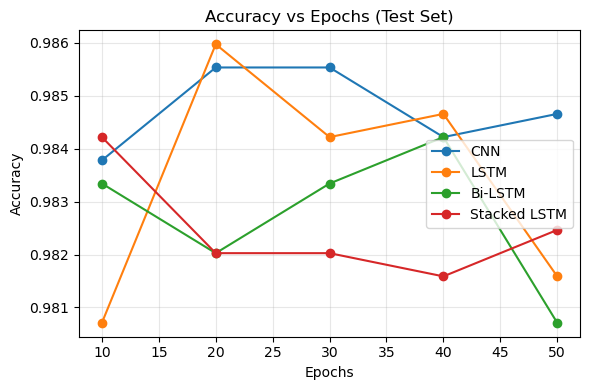

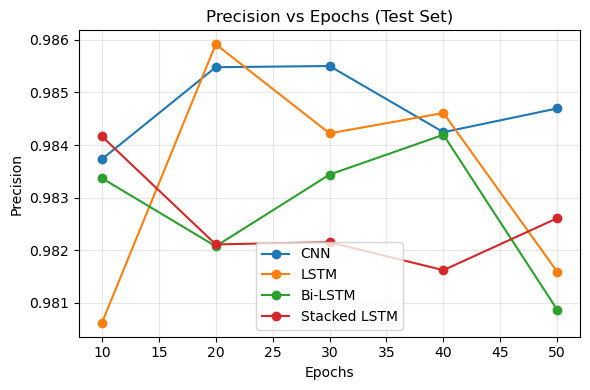

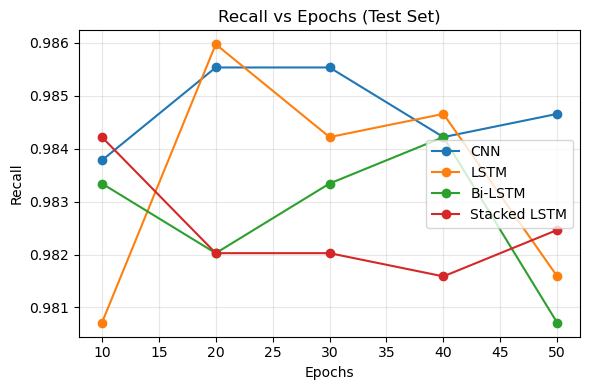

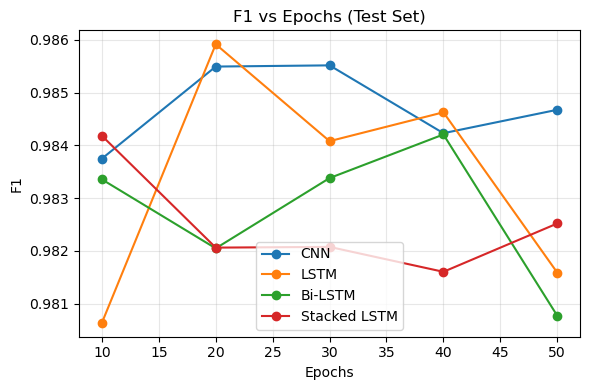

In [ ]:

import os, time, warnings, random
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
random.seed(42)
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.optimizers import Adam
from pathlib import Path
candidates = [
    Path("Data/Hybrid_Augmented_TSAFE_Features.xlsx"),
    Path("../Data/Hybrid_Augmented_TSAFE_Features.xlsx"),
    Path("../data/Hybrid_Augmented_TSAFE_Features.xlsx"),
]
for p in candidates:
    if p.exists():
        file_path = str(p)
        break
else:
    raise FileNotFoundError(
        f"Could not find Excel. Tried: {candidates}. CWD={Path.cwd()}"
    )

df = pd.read_excel(file_path)
if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = (
            df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
        )
    else:
        raise ValueError(
            "Cannot create 'Plant_Destination' because 'Plant Code' or 'Destination Port' is missing."
        )

cat_features = [
    'Origin Port',
    'Carrier',
    'Plant Code',
    'Destination Port',
    'Plant_Destination',
]

num_features = [
    # Raw operational
    'Unit quantity', 'Weight', 'TPT',

    # Empirically validated augmented
    'TPT_per_Unit',
    'LeadTime_Deviation',
    'Weight_per_Unit',
    'log_UnitQty',
    'carrier_origin_risk',
    'route_cum_late_rate',
    'route_bb_mean',
    'carrier_bb_mean',
    'route_orders_last7d',
    'route_roll10_Weight_q90',

    # Temporal / additional
    'congestion_trend',
    'Weight_vsCarrierMean',
    'seq_pos_norm',
]
requested_cols = cat_features + num_features
missing = [c for c in requested_cols if c not in df.columns]
if missing:
    print(f"[WARN] These requested columns are missing and will be skipped: {missing}")
    cat_features = [c for c in cat_features if c in df.columns]
    num_features = [c for c in num_features if c in df.columns]
X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)
X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)
def calculate_metrics(y_true, y_score_or_pred):
    """
    Accepts probabilities or hard labels; if probs, threshold at 0.5.
    Returns Accuracy/Precision/Recall/F1 (weighted).
    """
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0, 1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1':        f1_score(y_true, y_pred, average='weighted', zero_division=1),
    }
def create_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model
dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
epoch_grid = [10, 20, 30, 40, 50]
results = []
for m in dl_models:
    for E in epoch_grid:
        mdl = create_model(m, X_train_dl.shape[1])
        t0 = time.time()
        # Train
        mdl.fit(X_train_dl, y_train_res, epochs=E, batch_size=256, verbose=0)
        # Inference
        proba = mdl.predict(X_test_dl, verbose=0).reshape(-1)
        duration = round(time.time() - t0, 2)
        # Metrics
        met = calculate_metrics(y_test, proba)
        met.update({'Model': m, 'Epochs': E, 'Time (s)': duration})
        results.append(met)
results_df = pd.DataFrame(results)
cols = ['Model', 'Epochs', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time (s)']
results_df = results_df[cols].sort_values(['Model', 'Epochs']).reset_index(drop=True)
print("\n=== DL Epoch Sweep Results (Test Set) ===")
print(results_df.to_string(index=False))
out_csv = "dl_epoch_sweep_results.csv"
results_df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    for m in dl_models:
        sub = results_df[results_df['Model'] == m]
        plt.plot(sub['Epochs'], sub[metric], marker='o', label=m)
    plt.title(f'{metric} vs Epochs (Test Set)')
    plt.xlabel('Epochs'); plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
